In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context("talk", font_scale=1.4)
import folium
from folium.plugins import HeatMap

In [2]:
news_coords = pd.read_csv('../tagnews/data/homicide-2015-lat-longs.csv')
news_coords = news_coords[['lat', 'long']].values

In [3]:
# Download from
# https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2
crimes = pd.read_csv('../tagnews/data/Crimes_-_2001_to_present.csv')

In [4]:
crimes.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [5]:
crimes = crimes.loc[crimes['Primary Type'] == 'HOMICIDE', :]
times = pd.to_datetime(crimes['Date'])
crimes = crimes.loc[('2015' <= times) & (times <= '2016')]
# crime_coords = crimes[['Latitude', 'Longitude']]
# crime_coords = crime_coords.loc[~pd.isnull(crime_coords).any(axis=1)]
cavc = crimes['Community Area'].value_counts()
com_area = pd.DataFrame(np.array([cavc.index, cavc.values.flatten()]).T, columns=['area', 'count'])
com_area['area'] = com_area['area'].astype(int)
com_area['area'] = com_area['area'].astype(str)
com_area.set_index('area', drop=False, inplace=True)

In [6]:
sorted(np.unique(news_coords, axis=0, return_counts=True)[1])[-5:]

[95, 181, 186, 304, 495]

In [7]:
import json
from collections import defaultdict
from shapely.geometry import shape, Point
# depending on your version, use: from shapely.geometry import shape, Point

# load GeoJSON file containing sectors
with open('com-areas.geojson') as f:
    js = json.load(f)

counts = defaultdict(lambda : 0)

for point in np.unique(news_coords, axis=0):
    point = Point([point[1], point[0]])
    for feature in js['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            counts[feature['properties']['area_num_1']] += 1

In [11]:
com_area['actual_proportions'] = com_area['count'] / com_area['count'].sum()
com_area['news_counts'] = pd.Series(dict(counts))
com_area['news_counts'].fillna(0, inplace=True)
com_area['news_proportions'] = com_area['news_counts'] / com_area['news_counts'].sum()
com_area['news_minus_actual'] = com_area['news_proportions'] - com_area['actual_proportions']

In [13]:
m = folium.Map(location=[41.84871, -87.6298],
               zoom_start=11,
               tiles='cartodbpositron')

m.choropleth(geo_data='../tagnews/data/Boundaries - Community Areas (current).geojson',
             name='homicide',
             data=com_area,
             columns=['area', 'news_minus_actual'],
             key_on='feature.properties.area_num_1',
             threshold_scale=[-.04, -.02, 0, .02, .04],
             fill_color='PRGn', fill_opacity=0.7, line_opacity=0.2,
             legend_name='News under reporting (-) vs. over reporting (+)')
folium.LayerControl().add_to(m)

# for coord in np.unique(news_coords, axis=0):
#     folium.Marker(coord, icon=folium.Icon(color='gray', icon='newspaper', prefix='fa')).add_to(m)
# for coord in np.unique(crime_coords, axis=0):
#     folium.Marker(coord, icon=folium.Icon(color='blue', icon='gavel', prefix='fa')).add_to(m)

# HeatMap(np.unique(news_coords, axis=0).tolist()).add_to(m)

# folium.GeoJson(
#     'com-areas.geojson',
#     name='geojson'
# ).add_to(m)

m.save('homicide-map.html')

In [34]:
m = folium.Map(location=[41.84871, -87.6298],
               zoom_start=11,
               tiles='cartodbpositron')

HeatMap(np.unique(news_coords, axis=0).tolist(),
        min_opacity=0.05,
        max_val=.4).add_to(m)

m.save('homicide-heatmap-map.html')

In [26]:
HeatMap?

Init signature: HeatMap(data, name=None, min_opacity=0.5, max_zoom=18, max_val=1.0, radius=25, blur=15, gradient=None, overlay=True)
Docstring:     
Create a Heatmap layer

Parameters
----------
data : list of points of the form [lat, lng] or [lat, lng, weight]
    The points you want to plot.
    You can also provide a numpy.array of shape (n,2) or (n,3).
name : str
    The name of the layer that will be created.
min_opacity  : default 1.
    The minimum opacity the heat will start at.
max_zoom : default 18
    Zoom level where the points reach maximum intensity (as intensity
    scales with zoom), equals maxZoom of the map by default
max_val : float, default 1.
    Maximum point intensity
radius : int, default 25
    Radius of each "point" of the heatmap
blur : int, default 15
    Amount of blur
gradient : dict, default None
    Color gradient config. e.g. {0.4: 'blue', 0.65: 'lime', 1: 'red'}
File:           c:\users\kevin.rose\appdata\local\continuum\anaconda2\envs\cjp\lib\site-pac

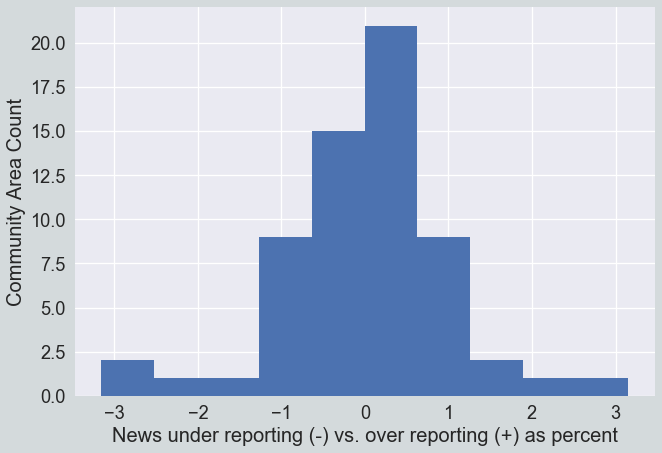

In [19]:
(com_area['news_minus_actual'] * 100).hist()
plt.xlim(np.array(max(abs(np.array(plt.gca().get_xlim())))) * [-1, 1])
plt.xlabel('News under reporting (-) vs. over reporting (+) as percent')
plt.ylabel('Community Area Count')
plt.gcf().set_facecolor(np.array([212, 218, 220]) / 255)
plt.show()

In [24]:
com_area

,area,count,actual_proportions,news_counts,news_proportions,news_minus_actual
area,,,,,,
25,25,50.0,0.100200,63,0.070312,-0.029888
44,44,23.0,0.046092,13,0.014509,-0.031583
29,29,23.0,0.046092,33,0.036830,-0.009262
68,68,22.0,0.044088,23,0.025670,-0.018419
23,23,18.0,0.036072,36,0.040179,0.004106
43,43,18.0,0.036072,34,0.037946,0.001874
67,67,18.0,0.036072,23,0.025670,-0.010403
69,69,18.0,0.036072,43,0.047991,0.011919
49,49,18.0,0.036072,25,0.027902,-0.008170
